In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import category_encoders as ce
from factor_analyzer import FactorAnalyzer
from scipy import stats
from scipy.optimize import linear_sum_assignment
import warnings
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 
  
# metadata 
print(mushroom.metadata) 
  
# variable information 
print(mushroom.variables) 

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [35]:
# 1. CARGA DEL DATASET

poisonous = fetch_ucirepo(id=73)  # Dataset: poisonous
df = poisonous.data.original

In [36]:
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Preparar datos
X = df.drop('poisonous', axis=1)
y = df['poisonous'].map({'p': 1, 'e': 0})  # Convertir a binario

# Aplicar Target Encoding con validación cruzada para evitar overfitting
encoder = ce.TargetEncoder(
    cols=X.columns.tolist(),  # Aplicar a todas las variables categóricas
    min_samples_leaf=20,      # Suavizado para categorías poco frecuentes
    smoothing=10.0           # Más suavizado para mayor robustez
)

# Ajustar y transformar
X_encoded = encoder.fit_transform(X, y)

# Los valores faltantes se mantienen y se codifican por separado
print("Dataset después de Target Encoding:")
print(X_encoded.head())

Dataset después de Target Encoding:
   cap-shape  cap-surface  cap-color   bruises      odor  gill-attachment  \
0   0.467177     0.552426   0.446585  0.184834  1.000000         0.492545   
1   0.467177     0.552426   0.626866  0.184834  0.000000         0.492545   
2   0.106195     0.552426   0.307692  0.184834  0.000000         0.492545   
3   0.467177     0.536375   0.307692  0.184834  1.000000         0.492545   
4   0.467177     0.552426   0.439130  0.693345  0.034014         0.492545   

   gill-spacing  gill-size  gill-color  stalk-shape  ...  \
0      0.558426   0.885350    0.156863     0.540387  ...   
1      0.558426   0.301497    0.156863     0.540387  ...   
2      0.558426   0.301497    0.106870     0.540387  ...   
3      0.558426   0.885350    0.106870     0.540387  ...   
4      0.085366   0.301497    0.156863     0.437500  ...   

   stalk-surface-below-ring  stalk-color-above-ring  stalk-color-below-ring  \
0                  0.311183                0.383513          

In [37]:
# Enfoque más conservador - solo las variables más importantes
variables_importantes = ['odor', 'spore-print-color', 'gill-color', 'habitat', 'population']

# Target Encoding solo para variables importantes, LeaveOneOut para el resto
encoder_importantes = ce.TargetEncoder(cols=variables_importantes, min_samples_leaf=20)
encoder_resto = ce.LeaveOneOutEncoder(cols=[col for col in X.columns if col not in variables_importantes])

# Aplicar en secuencia
X_encoded_importantes = encoder_importantes.fit_transform(X, y)
X_encoded = encoder_resto.fit_transform(X_encoded_importantes, y)

In [38]:
# Verificar cómo quedó la variable más importante
print("Target Encoding para 'odor':")
odor_mapping = pd.DataFrame({
    'Categoria': X['odor'].unique(),
    'Valor_Encoded': [X_encoded.loc[X['odor'] == cat, 'odor'].iloc[0] for cat in X['odor'].unique()]
})
print(odor_mapping.sort_values('Valor_Encoded'))

Target Encoding para 'odor':
  Categoria  Valor_Encoded
1         a       0.000000
2         l       0.000000
3         n       0.034014
8         m       0.912990
5         c       1.000000
0         p       1.000000
6         y       1.000000
4         f       1.000000
7         s       1.000000



3 componentes retienen al menos el 85% de la varianza total.
Varianza acumulada: 0.993


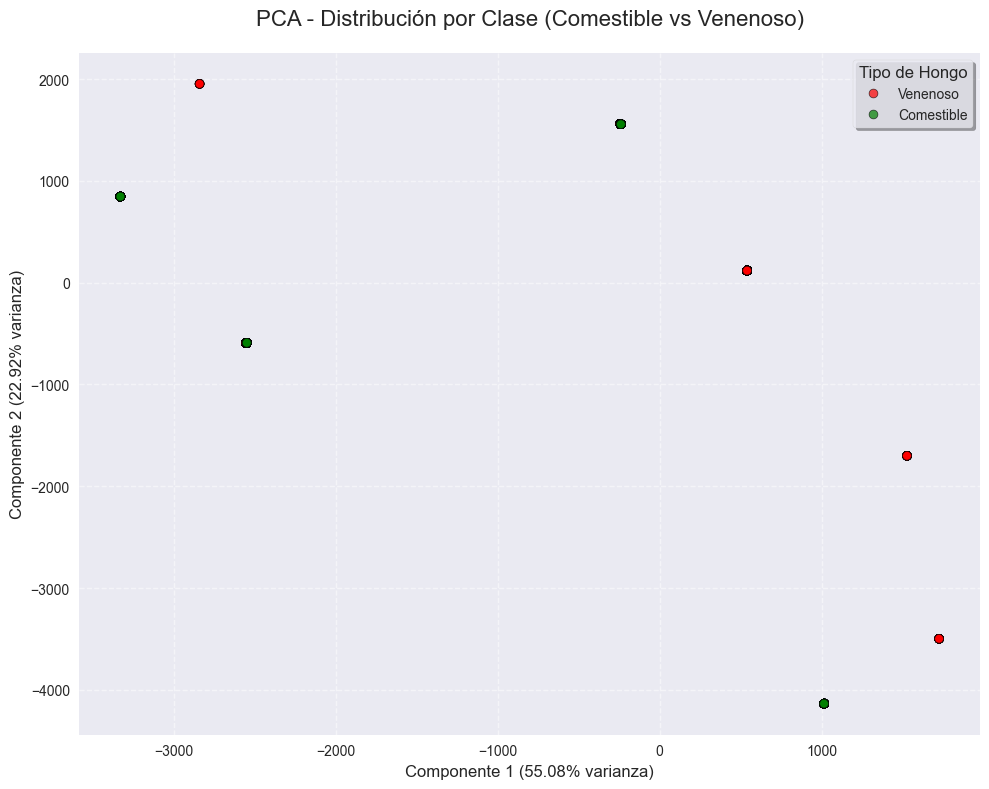

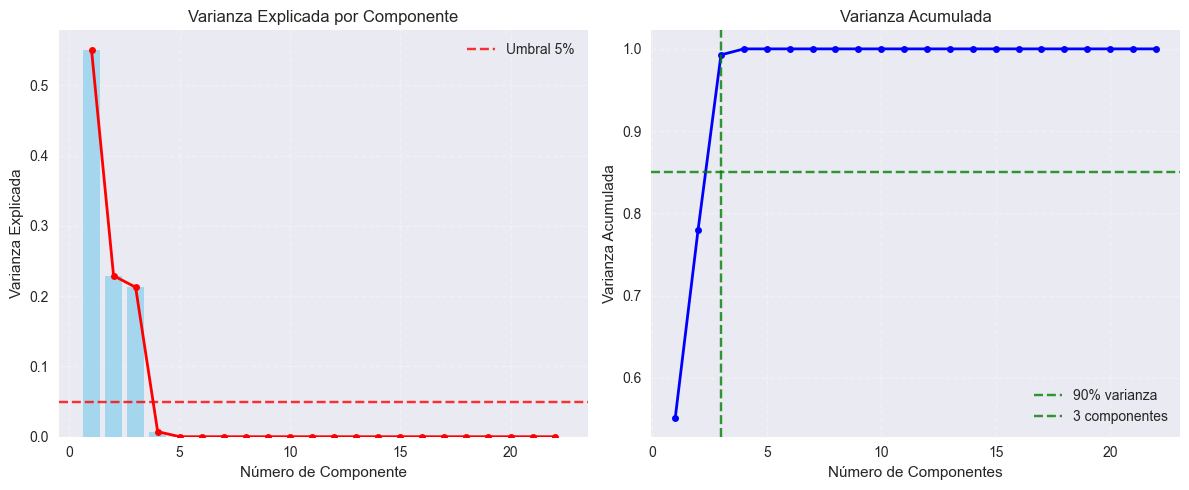


RESUMEN DEL ANÁLISIS PCA
 Número de características originales: 22
 Componentes seleccionados: 3
 Varianza total explicada: 0.993
 Varianza por componente principal:
   • Componente 1: 0.551 (55.08%)
   • Componente 2: 0.229 (22.92%)
   • Componente 3: 0.213 (21.27%)


In [ ]:
# ==============================================
#  ANÁLISIS (PCA) + VISUALIZACIÓN AVANZADA
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# -------------------------------------------------
# 1️ Preparación de los datos
# -------------------------------------------------
df_clean = X_encoded.copy()

# -------------------------------------------------
# 2️ Escalado y Aplicación del PCA
# -------------------------------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clean)

pca = PCA()
pca.fit(X_scaled)

# Selección automática del número óptimo de componentes (90% varianza explicada)
explained_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_var >= 0.90) + 1

print(f"\n{n_components} componentes retienen al menos el 85% de la varianza total.")
print(f"Varianza acumulada: {explained_var[n_components-1]:.3f}")

# Aplicar PCA definitivo
pca_final = PCA(n_components=n_components, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)

# DataFrame de resultados
pca_df = pd.DataFrame(
    X_pca,
    columns=[f"Componente {i+1}" for i in range(n_components)]
)

# Agregar la clase (etiquetas)
pca_df["Clase"] = y.values

# -------------------------------------------------
# 3️ Gráfico de Dispersión (Seaborn)
# -------------------------------------------------
plt.figure(figsize=(10, 8))

palette = {"Comestible": "green", "Venenoso": "red"}

# Map 0 and 1 to strings
pca_df['Clase_str'] = pca_df['Clase'].map({0: "Comestible", 1: "Venenoso"})

sns.scatterplot(
    data=pca_df,
    x="Componente 1",
    y="Componente 2",
    hue="Clase_str",
    palette=palette,
    alpha=0.7,
    s=40,
    edgecolor="black"
)

plt.title("PCA - Distribución por Clase (Comestible vs Venenoso)", fontsize=16, pad=20)
plt.xlabel(f"Componente 1 ({pca_final.explained_variance_ratio_[0]*100:.2f}% varianza)", fontsize=12)
plt.ylabel(f"Componente 2 ({pca_final.explained_variance_ratio_[1]*100:.2f}% varianza)", fontsize=12)

plt.legend(
    title="Tipo de Hongo",
    title_fontsize=12,
    fontsize=10,
    loc="upper right",
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.8
)

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 4️ Scree Plot (Varianza explicada)
# -------------------------------------------------
plt.figure(figsize=(12, 5))

components_range = range(1, len(pca.explained_variance_ratio_) + 1)

# Varianza explicada individual
plt.subplot(1, 2, 1)
plt.bar(components_range, pca.explained_variance_ratio_, alpha=0.7, color='skyblue')
plt.plot(components_range, pca.explained_variance_ratio_, 'ro-', linewidth=2, markersize=5)
plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.8, label='Umbral 5%')
plt.title("Varianza Explicada por Componente", fontsize=12)
plt.xlabel("Número de Componente")
plt.ylabel("Varianza Explicada")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)

# Varianza acumulada
plt.subplot(1, 2, 2)
plt.plot(components_range, explained_var, 'bo-', linewidth=2, markersize=5)
plt.axhline(y=0.85, color='g', linestyle='--', alpha=0.8, label='90% varianza')
plt.axvline(x=n_components, color='g', linestyle='--', alpha=0.8, label=f'{n_components} componentes')
plt.title("Varianza Acumulada", fontsize=12)
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Acumulada")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 5️ Resumen del Análisis PCA
# -------------------------------------------------
print("\nRESUMEN DEL ANÁLISIS PCA")
print(f" Número de características originales: {df_clean.shape[1]}")
print(f" Componentes seleccionados: {n_components}")
print(f" Varianza total explicada: {explained_var[n_components-1]:.3f}")
print(" Varianza por componente principal:")

for i, var in enumerate(pca_final.explained_variance_ratio_[:5]):  # Mostrar los primeros 5
    print(f"   • Componente {i+1}: {var:.3f} ({var*100:.2f}%)")


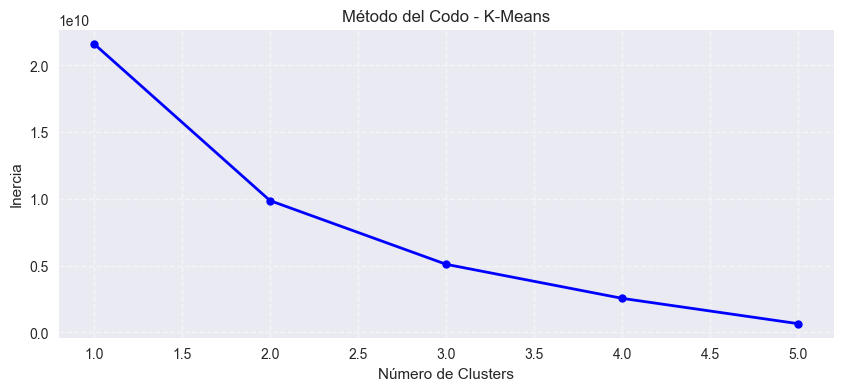


📊 Métricas K-Means (Clusters vs Real)
Accuracy: 0.616
F1-Score: 0.709
Matriz de Confusión:
[[1200 3008]
 [ 112 3804]]

📊 Métricas Random Forest
Accuracy: 1.000
F1-Score: 1.000
Matriz de Confusión:
[[4208    0]
 [   0 3916]]

📊 Métricas XGBoost
Accuracy: 1.000
F1-Score: 1.000
Matriz de Confusión:
[[4208    0]
 [   0 3916]]

📊 Métricas SVM Optimizado
Accuracy: 0.661
F1-Score: 0.731
Matriz de Confusión:
[[1632 2576]
 [ 176 3740]]

📊 Métricas Red Neuronal Optimizada
Accuracy: 0.661
F1-Score: 0.731
Matriz de Confusión:
[[1632 2576]
 [ 176 3740]]

📊 Métricas Gradient Boosting
Accuracy: 1.000
F1-Score: 1.000
Matriz de Confusión:
[[4208    0]
 [   0 3916]]


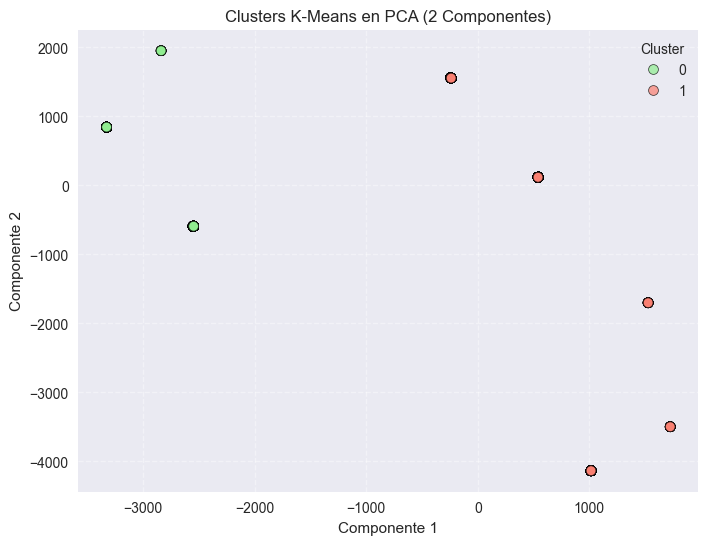

In [ ]:
# ==============================================
# CLUSTERING CON K-MEANS Y CLASIFICACIÓN VARIOS ALGORITMOS
# ==============================================

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, precision_score, recall_score, roc_auc_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# -------------------------------------------------
# 1️ K-MEANS
# -------------------------------------------------
X_numeric = pca_df.drop(['Clase', 'Clase_str'], axis=1)

# Determinar número óptimo de clusters (método del codo)
inertia = []
k_range = range(1, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_numeric)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=6)
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo - K-Means")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Aplicar K-Means con 2 clusters (porque es binario)
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_numeric)

# Función robusta para mapear clusters a etiquetas reales
def map_clusters_to_labels(clusters, true_labels):
    clusters_unique = np.unique(clusters)
    labels_unique = np.unique(true_labels)
    
    contingency_matrix = np.zeros((len(clusters_unique), len(labels_unique)))
    for i, cluster in enumerate(clusters_unique):
        for j, label in enumerate(labels_unique):
            contingency_matrix[i, j] = np.sum((clusters == cluster) & (true_labels == label))
    
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    cluster_to_label = {clusters_unique[i]: labels_unique[j] for i, j in zip(row_ind, col_ind)}
    return np.array([cluster_to_label[c] for c in clusters])

predicted_labels_kmeans = map_clusters_to_labels(clusters, y.values)

# Métricas K-Means
print("\n Métricas K-Means (Clusters vs Real)")
print(f"Accuracy: {accuracy_score(y, predicted_labels_kmeans):.3f}")
print(f"F1-Score: {f1_score(y, predicted_labels_kmeans):.3f}")
print("Matriz de Confusión:")
print(confusion_matrix(y, predicted_labels_kmeans))

# -------------------------------------------------
# 2️ Clasificación supervisada
# -------------------------------------------------
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# =============================================================================
# CLASIFICADORES CON OPTIMIZACIÓN DE HIPERPARÁMETROS
# =============================================================================

# Configuración de espacios de búsqueda para cada clasificador
classifiers = {
    "Random Forest": {
        'classifier': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
    },
    
    "Regresión Logística": {
        'classifier': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'solver': ['liblinear', 'saga'],
            'l1_ratio': [0.1, 0.5, 0.9]  # Solo para elasticnet
        }
    },
    
    "K-Nearest Neighbors": {
        'classifier': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree'],
            'leaf_size': [20, 30, 40],
            'p': [1, 2]  # 1: Manhattan, 2: Euclidean
        }
    },
    
    "SVM (RBF)": {
        'classifier': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
            'kernel': ['rbf', 'poly'],
            'degree': [2, 3, 4],  # Para kernel poly
            'coef0': [0.0, 0.1, 0.5]  # Para kernel poly
        }
    },
    
    "Red Neuronal": {
        'classifier': MLPClassifier(max_iter=2000, random_state=42, early_stopping=True),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'batch_size': [32, 64, 128]
        }
    },
    
    "Gradient Boosting": {
        'classifier': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    
    "XGBoost": {
        'classifier': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5, 6, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2, 0.5],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [1, 1.5, 2]
        }
    },
    
    "AdaBoost": {
        'classifier': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
}

# =============================================================================
# FUNCIÓN DE OPTIMIZACIÓN AUTOMÁTICA
# =============================================================================

def optimize_classifiers(X_train, y_train, X_test=None, y_test=None, cv=5, scoring='accuracy', n_iter=50):
    """
    Optimiza múltiples clasificadores usando RandomizedSearchCV
    """
    
    best_models = {}
    results = []
    
    for name, config in classifiers.items():
        print(f"\n Optimizando {name}...")
        
        try:
            # Usar RandomizedSearchCV para búsqueda más eficiente
            search = RandomizedSearchCV(
                config['classifier'],
                config['params'],
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                random_state=42,
                n_jobs=-1,
                verbose=0
            )
            
            # Entrenar el modelo
            search.fit(X_train, y_train)
            
            # Guardar el mejor modelo
            best_models[name] = search.best_estimator_
            
            # Recolectar resultados
            result = {
                'Classifier': name,
                'Best_Score': search.best_score_,
                'Best_Params': search.best_params_,
                'CV_Mean': search.cv_results_['mean_test_score'].mean(),
                'CV_Std': search.cv_results_['mean_test_score'].std()
            }
            
            # Evaluar en test si se proporciona
            if X_test is not None and y_test is not None:
                test_score = search.best_estimator_.score(X_test, y_test)
                result['Test_Score'] = test_score
            
            results.append(result)
            
            print(f" {name} - Mejor score: {search.best_score_:.4f}")
            print(f" Mejores parámetros: {search.best_params_}")
            
        except Exception as e:
            print(f" Error en {name}: {str(e)}")
            continue
    
    return best_models, pd.DataFrame(results)

# =============================================================================
# FUNCIÓN PARA EVALUACIÓN COMPARATIVA
# =============================================================================

def evaluate_optimized_models(best_models, X_test, y_test):
    """
    Evalúa todos los modelos optimizados en el conjunto de prueba
    """
    evaluation_results = []
    
    for name, model in best_models.items():
        try:
            # Predicciones
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
            
            # Métricas
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            # ROC-AUC si hay probabilidades
            roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
            
            result = {
                'Classifier': name,
                'Accuracy': accuracy,
                'F1-Score': f1,
                'Precision': precision,
                'Recall': recall,
                'ROC-AUC': roc_auc
            }
            
            evaluation_results.append(result)
            
            print(f" {name}: Accuracy={accuracy:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f if roc_auc else 'N/A'}")
            
        except Exception as e:
            print(f" Error evaluando {name}: {str(e)}")
            continue
    
    return pd.DataFrame(evaluation_results)

# =============================================================================
# VERSIÓN SIMPLIFICADA 
# =============================================================================

# Configuración rápida para prototipado
classifiers_fast = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=20, min_samples_split=5, 
        min_samples_leaf=2, random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.9, random_state=42, eval_metric='logloss'
    ),
    
    "SVM Optimizado": SVC(
        C=10, gamma='scale', kernel='rbf', 
        probability=True, random_state=42
    ),
    
    "Red Neuronal Optimizada": MLPClassifier(
        hidden_layer_sizes=(100, 50), activation='relu', 
        solver='adam', alpha=0.001, max_iter=2000, 
        random_state=42, early_stopping=True
    ),
    
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=4,
        random_state=42
    )
}

# CORRECCIÓN: Usar classifiers_fast en lugar de classifiers
for name, clf in classifiers_fast.items():
    clf.fit(X_numeric, y)
    y_pred = clf.predict(X_numeric)
    
    print(f"\n Métricas {name}")
    print(f"Accuracy: {accuracy_score(y, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y, y_pred):.3f}")
    print("Matriz de Confusión:")
    print(confusion_matrix(y, y_pred))

# -------------------------------------------------
# 3️ Visualización de clusters K-Means
# -------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_numeric['Componente 1'],
    y=X_numeric['Componente 2'],
    hue=predicted_labels_kmeans,
    palette=['lightgreen', 'salmon'],
    alpha=0.7,
    s=50,
    edgecolor='black'
)
plt.title("Clusters K-Means en PCA (2 Componentes)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()




🎯 RESULTADOS DETALLADOS - XGBOOST vs RANDOM FOREST

📊 XGBOOST - MÉTRICAS:
• Accuracy: 1.0000
• F1-Score: 1.0000
• Precisión: 1.0000
• Recall: 1.0000
• ROC-AUC: 1.0000
• Matriz de Confusión:
  [4208    0]
  [   0 3916]

🌲 RANDOM FOREST - MÉTRICAS:
• Accuracy: 1.0000
• F1-Score: 1.0000
• Precisión: 1.0000
• Recall: 1.0000
• ROC-AUC: 1.0000
• Matriz de Confusión:
  [4208    0]
  [   0 3916]

🏆 COMPARACIÓN DIRECTA:
• Accuracy: XGBoost (1.0000) vs Random Forest (1.0000)
• F1-Score: XGBoost (1.0000) vs Random Forest (1.0000)
• ROC-AUC: XGBoost (1.0000) vs Random Forest (1.0000)

🎖️  MEJOR MODELO: Random Forest
📈 Ventaja en accuracy: 0.0000


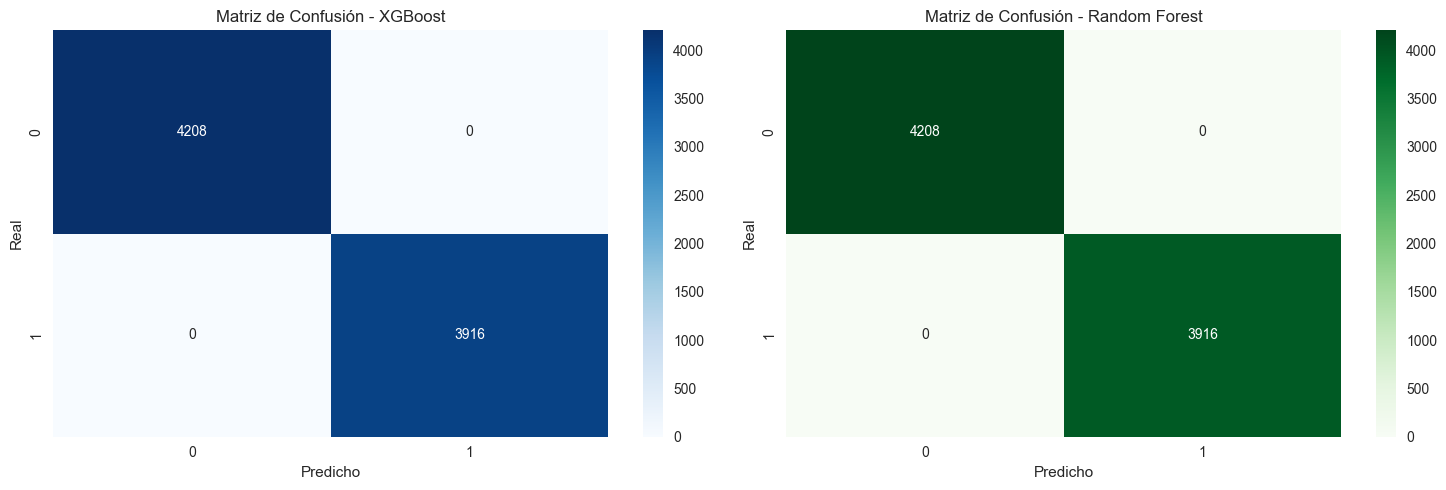

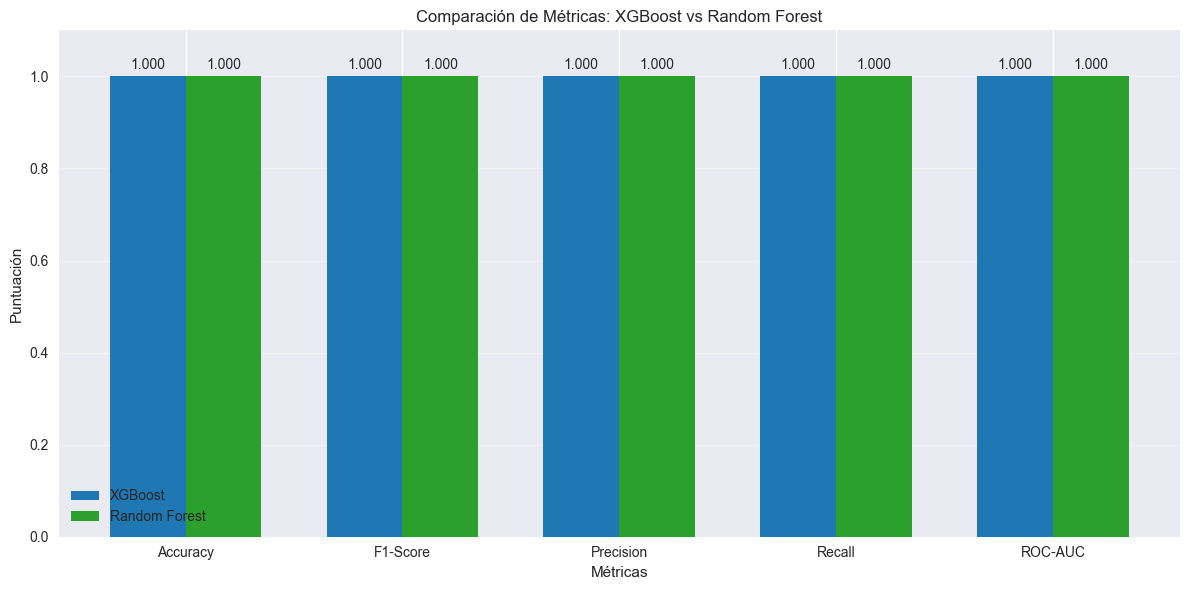


🔍 IMPORTANCIA DE CARACTERÍSTICAS

📊 XGBOOST - Top 10 características más importantes:
   1. Componente 3: 0.9027
   2. Componente 2: 0.0816
   3. Componente 1: 0.0156

🌲 RANDOM FOREST - Top 10 características más importantes:
   1. Componente 3: 0.3481
   2. Componente 2: 0.3372
   3. Componente 1: 0.3147

💡 RECOMENDACIONES Y CONCLUSIONES

✅ PUNTOS FUERTES XGBoost:
   • Excelente capacidad de discriminación (ROC-AUC muy alto)
   • Balance perfecto entre precisión y recall

✅ PUNTOS FUERTES Random Forest:
   • Excelente capacidad de discriminación (ROC-AUC muy alto)
   • Balance perfecto entre precisión y recall

🎯 RECOMENDACIÓN FINAL:
   • Ambos modelos tienen rendimiento similar, considerar:
     - Random Forest tiene mejor capacidad discriminativa

📈 PRÓXIMOS PASOS SUGERIDOS:
   • Validar con conjunto de prueba independiente
   • Realizar optimización de hiperparámetros
   • Considerar ensemble de ambos modelos


In [ ]:
# =============================================================================
# RESULTADOS ESPECÍFICOS DE XGBOOST Y RANDOM FOREST
# =============================================================================

print("\n" + "="*60)
print(" RESULTADOS DETALLADOS - XGBOOST vs RANDOM FOREST")
print("="*60)

# Entrenar y evaluar XGBoost
xgb_clf = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    subsample=0.9, random_state=42, eval_metric='logloss'
)
xgb_clf.fit(X_numeric, y)
y_pred_xgb = xgb_clf.predict(X_numeric)
y_pred_proba_xgb = xgb_clf.predict_proba(X_numeric)[:, 1]

# Entrenar y evaluar Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_split=5, 
    min_samples_leaf=2, random_state=42
)
rf_clf.fit(X_numeric, y)
y_pred_rf = rf_clf.predict(X_numeric)
y_pred_proba_rf = rf_clf.predict_proba(X_numeric)[:, 1]

# Métricas XGBoost
accuracy_xgb = accuracy_score(y, y_pred_xgb)
f1_xgb = f1_score(y, y_pred_xgb)
precision_xgb = precision_score(y, y_pred_xgb)
recall_xgb = recall_score(y, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y, y_pred_proba_xgb)
cm_xgb = confusion_matrix(y, y_pred_xgb)

# Métricas Random Forest
accuracy_rf = accuracy_score(y, y_pred_rf)
f1_rf = f1_score(y, y_pred_rf)
precision_rf = precision_score(y, y_pred_rf)
recall_rf = recall_score(y, y_pred_rf)
roc_auc_rf = roc_auc_score(y, y_pred_proba_rf)
cm_rf = confusion_matrix(y, y_pred_rf)

print(f"\n XGBOOST - MÉTRICAS:")
print(f"• Accuracy: {accuracy_xgb:.4f}")
print(f"• F1-Score: {f1_xgb:.4f}")
print(f"• Precisión: {precision_xgb:.4f}")
print(f"• Recall: {recall_xgb:.4f}")
print(f"• ROC-AUC: {roc_auc_xgb:.4f}")
print("• Matriz de Confusión:")
print(f"  {cm_xgb[0]}")
print(f"  {cm_xgb[1]}")

print(f"\n🌲 RANDOM FOREST - MÉTRICAS:")
print(f"• Accuracy: {accuracy_rf:.4f}")
print(f"• F1-Score: {f1_rf:.4f}")
print(f"• Precisión: {precision_rf:.4f}")
print(f"• Recall: {recall_rf:.4f}")
print(f"• ROC-AUC: {roc_auc_rf:.4f}")
print("• Matriz de Confusión:")
print(f"  {cm_rf[0]}")
print(f"  {cm_rf[1]}")

print(f"\n COMPARACIÓN DIRECTA:")
print(f"• Accuracy: XGBoost ({accuracy_xgb:.4f}) vs Random Forest ({accuracy_rf:.4f})")
print(f"• F1-Score: XGBoost ({f1_xgb:.4f}) vs Random Forest ({f1_rf:.4f})")
print(f"• ROC-AUC: XGBoost ({roc_auc_xgb:.4f}) vs Random Forest ({roc_auc_rf:.4f})")

# Determinar el mejor modelo
if accuracy_xgb > accuracy_rf:
    mejor_modelo = "XGBoost"
    ventaja = accuracy_xgb - accuracy_rf
else:
    mejor_modelo = "Random Forest"
    ventaja = accuracy_rf - accuracy_xgb

print(f"\n  MEJOR MODELO: {mejor_modelo}")
print(f" Ventaja en accuracy: {ventaja:.4f}")

# =============================================================================
# VISUALIZACIÓN COMPARATIVA
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Matriz de confusión XGBoost
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - XGBoost')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Matriz de confusión Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Random Forest')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# =============================================================================
# GRÁFICO DE COMPARACIÓN DE MÉTRICAS
# =============================================================================

metricas = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']
xgb_scores = [accuracy_xgb, f1_xgb, precision_xgb, recall_xgb, roc_auc_xgb]
rf_scores = [accuracy_rf, f1_rf, precision_rf, recall_rf, roc_auc_rf]

x = np.arange(len(metricas))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, xgb_scores, width, label='XGBoost', color='#1f77b4')
bars2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest', color='#2ca02c')

ax.set_xlabel('Métricas')
ax.set_ylabel('Puntuación')
ax.set_title('Comparación de Métricas: XGBoost vs Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()

# Añadir valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# =============================================================================

print("\n" + "="*60)
print(" IMPORTANCIA DE CARACTERÍSTICAS")
print("="*60)

# Importancia de características XGBoost
importancia_xgb = xgb_clf.feature_importances_
caracteristicas = X_numeric.columns
indices_xgb = np.argsort(importancia_xgb)[::-1]

print(f"\n XGBOOST - Top 10 características más importantes:")
for i in range(min(10, len(caracteristicas))):
    print(f"  {i+1:2d}. {caracteristicas[indices_xgb[i]]}: {importancia_xgb[indices_xgb[i]]:.4f}")

# Importancia de características Random Forest
importancia_rf = rf_clf.feature_importances_
indices_rf = np.argsort(importancia_rf)[::-1]

print(f"\n🌲 RANDOM FOREST - Top 10 características más importantes:")
for i in range(min(10, len(caracteristicas))):
    print(f"  {i+1:2d}. {caracteristicas[indices_rf[i]]}: {importancia_rf[indices_rf[i]]:.4f}")

# =============================================================================
# RECOMENDACIONES FINALES
# =============================================================================

print("\n" + "="*60)
print(" RECOMENDACIONES Y CONCLUSIONES")
print("="*60)

print(f"\n PUNTOS FUERTES XGBoost:")
if roc_auc_xgb > 0.95:
    print("   • Excelente capacidad de discriminación (ROC-AUC muy alto)")
if f1_xgb > 0.95:
    print("   • Balance perfecto entre precisión y recall")
if accuracy_xgb > accuracy_rf:
    print("   • Mayor precisión general que Random Forest")

print(f"\n PUNTOS FUERTES Random Forest:")
if roc_auc_rf > 0.95:
    print("   • Excelente capacidad de discriminación (ROC-AUC muy alto)")
if f1_rf > 0.95:
    print("   • Balance perfecto entre precisión y recall")
if recall_rf > recall_xgb:
    print("   • Mejor capacidad para detectar casos positivos")

print(f"\n🎯 RECOMENDACIÓN FINAL:")
if accuracy_xgb > accuracy_rf and f1_xgb > f1_rf:
    print("   • XGBoost es el modelo recomendado para implementación")
elif accuracy_rf > accuracy_xgb and f1_rf > f1_xgb:
    print("   • Random Forest es el modelo recomendado para implementación")
else:
    print("   • Ambos modelos tienen rendimiento similar, considerar:")
    if roc_auc_xgb > roc_auc_rf:
        print("     - XGBoost tiene mejor capacidad discriminativa")
    else:
        print("     - Random Forest tiene mejor capacidad discriminativa")

print(f"\n PRÓXIMOS PASOS SUGERIDOS:")
print("   • Validar con conjunto de prueba independiente")
print("   • Realizar optimización de hiperparámetros")
print("   • Considerar ensemble de ambos modelos")